# Gaussian Process Regression from Scratch

In this notebook, I would like to go through a gaussian process (GP) regression implementation from scratch. The main components of the algorithm consist of:

* Parameter initialization
* Training via hyperparameter optimization
* Predictions with Variance Estimates

I will use inspiration from a few sources:

* Algorithm 2.1 
    - [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) - Rasmussen and Williams
* Chapter 18 
    - [Machine Learning: An Algorithmic Perspective](https://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html) - Stephen Marsland

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, cdist

### Sample Data

In [12]:
n_train = 30
n_test = 400
xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)
print('X training data:', xtrain.shape)
print('X testing data:', xtest.shape)

# Labels
ytrain = np.sin(xtrain) * np.exp(0.2 * xtrain) + np.random.randn(n_train, 1) * 0.3

X training data: (30, 1)
X testing data: (400, 1)


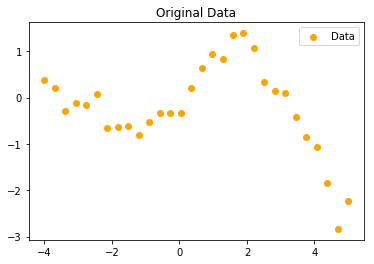

In [16]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, color='orange', label='Data')
ax.legend(loc='best')
ax.set_title('Original Data')
plt.show()

## Gaussian Process Class

In [158]:
class GaussianProcessRegressor(object):
    def __init__(self, kernel='ard'):
        self.kernel = 'ard'
    
    def fit(self, x, y):
        self.y_fit_ = y
        self.x_fit_ = x
        self.n_samples = x.shape[0]
        
        # initialize with heuristics
        self.length_scale = np.mean(pdist(x, metric='euclidean'))
        self.likelihood_variance = 1.0
        
        return self
    
    # Kernel Matrix
    def ard_kernel(self, x, y=None, length_scale):
        
        if y is None:
            dists = pdist( x / self.length_scale, metric='sqeuclidean')
            K = np.exp(-.5)
            K

### Kernel Function

In [38]:
from sklearn.metrics.pairwise import rbf_kernel

Taken from [stackoverflow](https://stackoverflow.com/questions/47271662/what-is-the-fastest-way-to-compute-an-rbf-kernel-in-python/47271663#47271663) post.

In [131]:
import numexpr as ne
from scipy.spatial.distance import pdist, squareform

# def rbf_kernelnumexp(x, gamma, var=1.0):
#     x_norm = - gamma * np.sum(x**2, axis=-1)
#     return ne.evaluate('v * exp(A + B + C)', {
#         'A': x_norm[:, None],
#         'B': x_norm[None, :],
#         'C': 2.0 * gamma * np.dot(x, x.T),
#         'g': gamma, 
#         'v': var
#     })
#     return None

def ard_kernel(x, length_scale, var=1.0):
    dists = pdist(x/length_scale,'sqeuclidean')
    K = np.exp(-.5 * dists)
    return squareform(K)

In [123]:
%timeit ard_kernel(x, length_scale=length_scale)

29.5 µs ± 600 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Parameters (Heuristic Initializations)

In [26]:
n_points = xtrain.shape[0]
x_fit = xtrain
length_scale = np.mean(pdist(x_fit, metric='euclidean'))
likelihood_variance = 1

print('Number of training points: {}'.format(n_points))
print('Lengthscale: {:.3f}'.format(length_scale))
print('Likelihood Variance: {}'.format(likelihood_variance))

Number of training points: 30
Lengthscale: 3.207
Likelihood Variance: 1


### Gradiant Descent (Marginal Likelihood)

#### Parameters

In [29]:
param_lengthscale = length_scale
length_scale_bounds = ((1e-20, None))
param_likelihood_variance = likelihood_variance
likelihood_variance_bounds = ((1e-10, None))

        
        theta0 = np.array([self.length_scale,
                           self.likelihood_variance])
        
        bounds = ((1e-20, None), # length scale
                  (1e-10, None)) # likelihood variance
        
        # gradient descent on marginal likelihood

#### Function to minimize

##### Marginal Log Likelihood

$$-\frac{1}{2}y^{\top}\left[{\bf K}+\sigma_y^2{\bf I}\right]y - \frac{1}{2}\log \left| {\bf K}+\sigma_y^2{\bf I} \right| - \frac{n}{2}\log 2\pi$$

In [157]:
from scipy.linalg import cholesky, solve

def log_posterior(theta, args):
    x, y = args
    print(x.shape, y.shape)
    n_samples = x.shape[0]
    # extract parameters
    length_scale_param = theta[0]
    likelihood_variance_param = theta[1]
    
    K = ard_kernel(x, length_scale=length_scale)

    # calculate the cholesky
    L = cholesky(K + theta[1]*np.eye(n_samples), lower=True)
    
    # solve for alpha
    weights = solve(L.T, solve(L, y))
    
    # solve for the log posterior
    log_p = -0.5 * np.dot(y.T, weights) \
            - np.sum( np.log( np.diag(L) )) \
            - 0.5 * n_samples * np.log(2 * np.pi)

    return -log_p

In [156]:
length_scale = np.ones(shape=x.shape[0])
variance = 1.0
theta = np.array([length_scale, variance])
args = (xtrain, ytrain)
temp = log_posterior(theta, args)
print(temp.shape)

(30, 1) (30, 1)
(1, 1)
(1, 1)


In [ ]:
def grad_log_posterior(theta, args):
    x, y = args
    

#### Scipy Solution